# **WIDS Kaggle Competition Feb2020**

### Installation and Imports

In [1]:
# install packages in notebook if needed
# !pip install plotly
# !python -m pip install --upgrade pip

In [2]:
import pandas as pd
import json
# import plotly.express as px

In [3]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [4]:
import numpy as np

In [5]:
# spark = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

### Download Datasets

Followed instructions to retrieve api key from kaggle: https://medium.com/widslapaz/explora-los-datos-wids-datathon-2020-36948397acea

In [7]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !touch '/root/.kaggle/kaggle.json'
# ######################################################################################

# #api_token = {"username":"XXXXXXXXXXX","key":"XXXXXXXXXXXXXXXX"}
# ######################################################################################

# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 /root/.kaggle/kaggle.json

In [8]:
# #download datasets
# !kaggle competitions download -c widsdatathon2020

# #unzip datasets
# !unzip training_v2.csv.zip 
# !unzip unlabeled.csv.zip

In [9]:
# #verify dataset are available
# !ls

### Load Dataset

In [10]:
# dictionary containing variable description and details
df_dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
print("Dataset dimension (rows, columns)  : ", df_dictionary.shape)
df_dictionary.sample(5)

Dataset dimension (rows, columns)  :  (188, 6)


,Category,Variable Name,Unit of Measure,Data Type,Description,Example
43,APACHE covariate,temp_apache,Degrees Celsius,numeric,The temperature measured during the first 24 h...,33
163,labs blood gas,d1_arterial_po2_max,Millimetres of mercury,numeric,The highest arterial partial pressure of oxyge...,80
35,APACHE covariate,intubated_apache,None,binary,Whether the patient was intubated at the time ...,0
129,labs,h1_albumin_max,None,numeric,The lowest albumin concentration of the patien...,30
135,labs,h1_calcium_max,mmol/L,numeric,The highest calcium concentration of the patie...,2.5


In [11]:
# Training dataset for exploration and model creation
df_training = pd.read_csv('training_v2.csv')
print("Dataset dimension (rows, columns)  : ", df_training.shape)
df_training.sample(5)

Dataset dimension (rows, columns)  :  (91713, 186)


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
89775,116974,39629,188,0,56.0,33.683923,0,African American,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
48937,126468,46052,200,0,61.0,27.444038,0,Caucasian,F,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
22390,85915,31239,32,0,74.0,26.715965,0,Caucasian,M,170.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
22226,25394,4781,32,0,66.0,21.819350,1,Caucasian,M,185.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
65589,71126,68556,19,0,35.0,24.965282,0,Caucasian,M,178.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [12]:
# unlabelled data for submission
df_unlabeled = pd.read_csv('unlabeled.csv')
print("Dataset dimension (rows, columns)  : ", df_unlabeled.shape)
df_unlabeled.sample(5)

Dataset dimension (rows, columns)  :  (39308, 186)


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
11109,36689,61393,86,NaN,77.0,39.593215,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
32974,109986,75688,163,NaN,25.0,27.202823,0,Caucasian,M,182.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
16653,55224,1668,42,NaN,85.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
16578,54972,91070,6,NaN,54.0,21.370140,0,Caucasian,F,162.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
3653,11858,115331,59,NaN,49.0,NaN,1,Caucasian,M,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


### Exploratory Data Analysis

In [13]:
print(df_training.dtypes.head())


encounter_id        int64
patient_id          int64
hospital_id         int64
hospital_death      int64
age               float64
dtype: object


In [14]:
# retrieve summary statistics of dataset
df_training.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# get ratio of hospital survival (0) or deaths (1)
df_training['hospital_death'].value_counts(normalize=True)


0    0.913698
1    0.086302
Name: hospital_death, dtype: float64

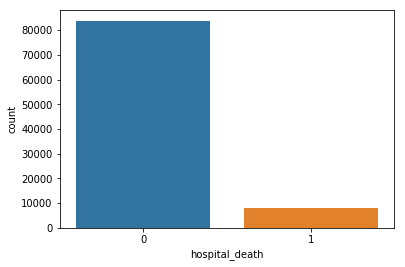

In [16]:
# sns.countplot(data = df_training, x = 'hospital_death')
sns.countplot(df_training["hospital_death"])


Visualize Categorical Data

In [17]:
#  Retrieve column names that are categorical 
categorical_cols = [c for c in df_training.columns if (1<df_training[c].nunique()) & (df_training[c].dtype != np.number)& (df_training[c].dtype != np.int64) ]

In [18]:
print(categorical_cols)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


In [19]:
df_categorical= df_training[categorical_cols+['hospital_death']]

In [60]:
df_categorical.isna().sum().sort_values(ascending=False)

hospital_admit_source    21409
apache_2_bodysystem       1662
apache_3j_bodysystem      1662
ethnicity                 1395
icu_admit_source           112
gender                      25
hospital_death               0
icu_type                     0
icu_stay_type                0
dtype: int64

In [65]:
df_categorical['ethnicity'].value_counts()

Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64

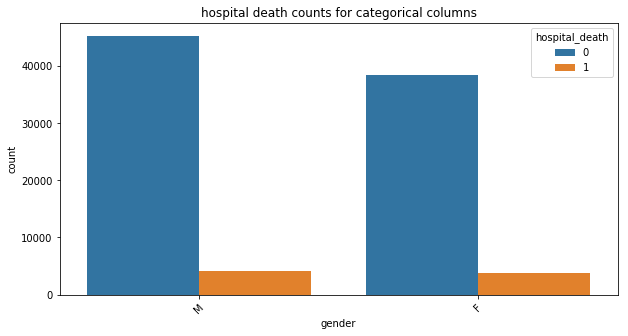

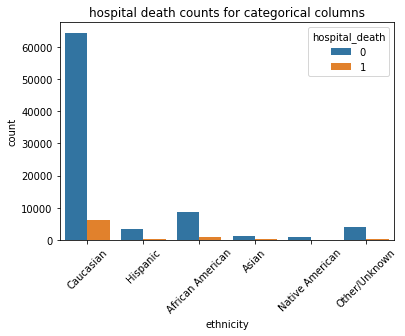

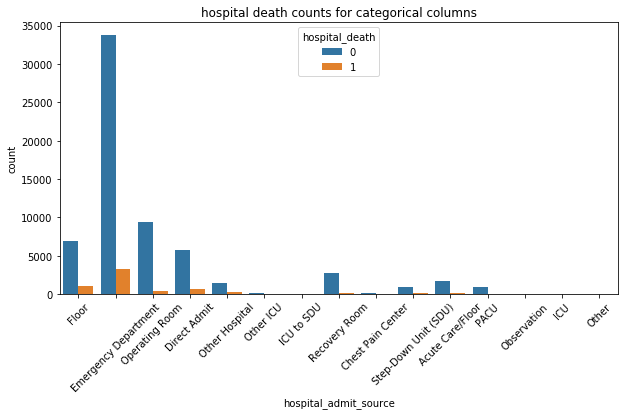

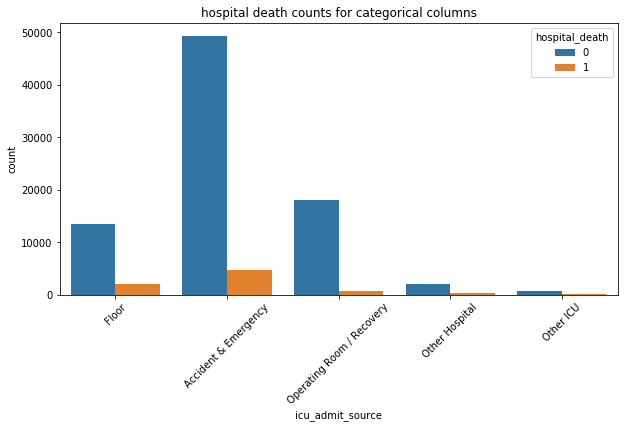

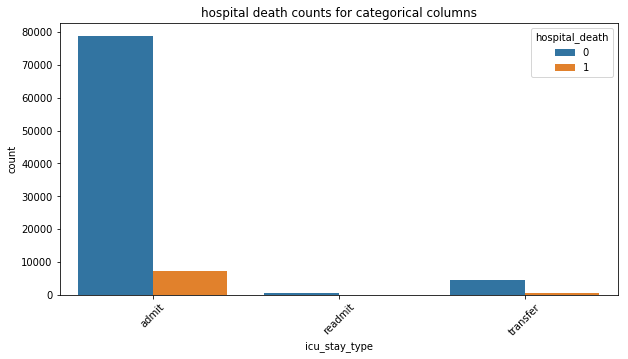

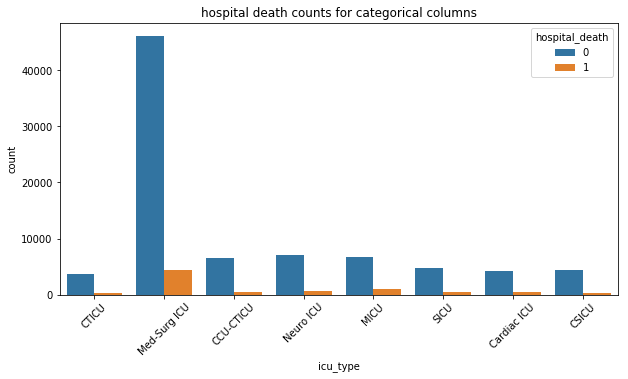

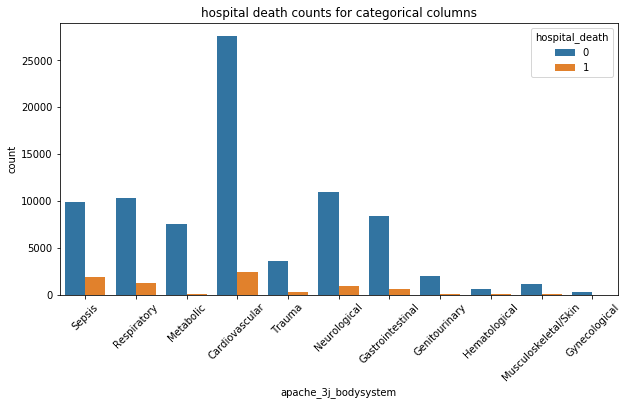

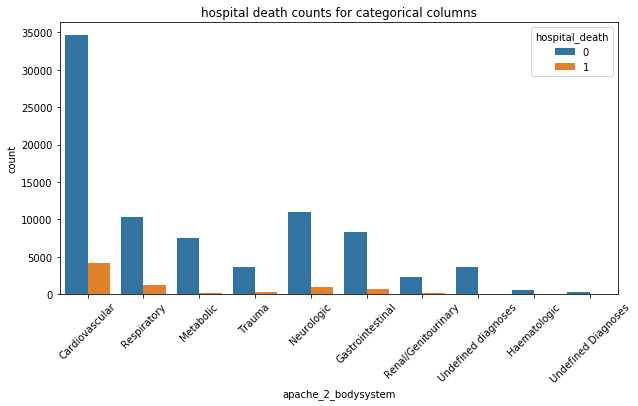

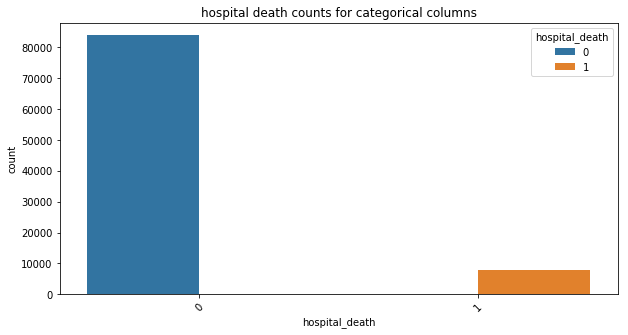

In [20]:
# plot categorical data by hospital death counts
for i, col in enumerate(df_categorical.columns):
    plt.figure(figsize=(10,5))
    plt.figure(i)
    sns.countplot(x=col, data=df_categorical,hue ='hospital_death').set_title("hospital death counts for categorical columns")
    plt.xticks(rotation=45)

C:\Users\wchan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\wchan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\wchan\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


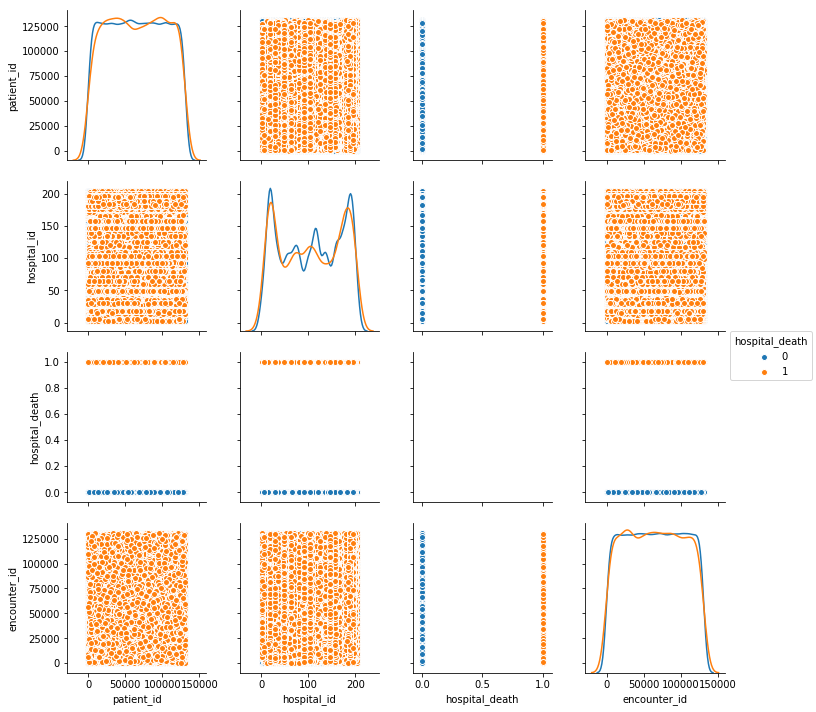

In [22]:
hospital = [
    'patient_id','hospital_id','hospital_death','encounter_id']
sns.pairplot(data=df_training,diag_kind='kde',vars=hospital,hue='hospital_death')
plt.show()

Find highly correlated variables to be removed

In [23]:
corr_matrix = df_training.corr().abs()
corr_matrix.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
encounter_id,1.000000,0.009575,0.004532,0.005243,0.003990,0.001068,0.002036,0.005400,0.000992,0.000570,...,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646
patient_id,0.009575,1.000000,0.007075,0.004877,0.006343,0.001380,0.001387,0.002902,0.001770,0.004412,...,0.003735,0.001625,0.002426,0.001307,0.000434,0.001667,0.000548,0.000844,0.002333,0.003065
hospital_id,0.004532,0.007075,1.000000,0.001255,0.008673,0.012874,0.052123,0.027895,0.004526,0.001285,...,0.006993,0.000283,0.004947,0.002962,0.011978,0.001362,0.000146,0.002992,0.002588,0.004730
hospital_death,0.005243,0.004877,0.001255,1.000000,0.111017,0.031247,0.093574,0.019526,0.000994,0.063316,...,0.311043,0.283913,0.004403,0.039453,0.015784,0.038864,0.043973,0.029788,0.018722,0.051105
age,0.003990,0.006343,0.008673,0.111017,1.000000,0.087077,0.067320,0.109937,0.024257,0.049872,...,0.143167,0.076275,0.029477,0.028065,0.077908,0.020061,0.025007,0.030310,0.023335,0.025924


In [35]:
# Upper triangle of correlations
threshold = 0.9

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
corr_cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(corr_cols_to_drop)
print('There are %d columns to remove.' % (len(corr_cols_to_drop)))

['apache_post_operative', 'paco2_for_ph_apache', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_min', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1

### **Missing Value Analysis**

In [25]:
#finding out missing values
missing_cnt = df_training.isna().sum().sort_values(ascending=False)
missing_percentage = (df_training.isna().sum()/df_training.isna().count()).sort_values(ascending=False)
missing_stat_df = pd.concat([missing_cnt,missing_percentage],axis=1,keys=('missing_cnt','missing_percentage')).reset_index()
missing_stat_df.head()

,index,missing_cnt,missing_percentage
0,h1_bilirubin_min,84619,0.922650
1,h1_bilirubin_max,84619,0.922650
2,h1_lactate_max,84369,0.919924
3,h1_lactate_min,84369,0.919924
4,h1_albumin_min,83824,0.913982


In [26]:
# missing values in training set (in percent)
missing_cols_above_threshold = missing_stat_df[missing_stat_df['missing_percentage'] > 0.9]
# X = X.drop(columns = train_missing)
print(missing_cols_above_threshold)

There are 6 columns with more than 90% missing values
              index  missing_cnt  missing_percentage
0  h1_bilirubin_min        84619            0.922650
1  h1_bilirubin_max        84619            0.922650
2    h1_lactate_max        84369            0.919924
3    h1_lactate_min        84369            0.919924
4    h1_albumin_min        83824            0.913982
5    h1_albumin_max        83824            0.913982


In [36]:
missing_cols_to_drop = missing_cols_above_threshold['index'].tolist()
print('There are %d columns with more than 90%% missing values' % len(missing_cols_to_drop))
print(missing_cols_to_drop)

There are 6 columns with more than 90% missing values
['h1_bilirubin_min', 'h1_bilirubin_max', 'h1_lactate_max', 'h1_lactate_min', 'h1_albumin_min', 'h1_albumin_max']


In [56]:
# plt.figure(figsize=(500,100))
# sns.barplot(y='total_na', x='index', data=df_missing_by_col_1[df_missing_by_col_1['total_na'] > 0])


### Clean training df

In [38]:
df_training_updated = df_training.drop(columns = corr_cols_to_drop+missing_cols_to_drop)

In [48]:
# Fill missing age with mean age
mean_age = df_training_updated['age'].mean()
df_training_updated['age'] = df_training_updated['age'].fillna(mean_age) 

In [50]:
print(mean_age)

62.309515917014345


In [52]:
df_training_updated['age'].isna().sum()#.sort_values(ascending=False)

0

In [51]:
# Fill missing bmi with mean bmi
mean_bmi = df_training_updated['bmi'].mean()
df_training_updated['bmi'] = df_training_updated['bmi'].fillna(mean_bmi) 
print(mean_bmi)

29.185817668574376


In [53]:
df_training_updated['bmi'].isna().sum()#.sort_values(ascending=False)

0

In [55]:
df_training_updated.isna().sum().sort_values(ascending=False)


h1_pao2fio2ratio_max      80195
h1_arterial_ph_max        76424
h1_arterial_po2_max       75945
h1_arterial_po2_min       75945
h1_calcium_max            75863
h1_diasbp_invasive_min    74928
h1_diasbp_invasive_max    74928
h1_sysbp_invasive_max     74915
h1_sysbp_invasive_min     74915
h1_mbp_invasive_max       74844
h1_mbp_invasive_min       74844
h1_sodium_max             72617
h1_potassium_max          72102
ph_apache                 70868
fio2_apache               70868
paco2_apache              70868
pao2_apache               70868
d1_lactate_max            68396
d1_lactate_min            68396
d1_diasbp_invasive_max    67984
d1_diasbp_invasive_min    67984
d1_sysbp_invasive_min     67959
d1_sysbp_invasive_max     67959
d1_mbp_invasive_max       67777
d1_mbp_invasive_min       67777
d1_pao2fio2ratio_min      66008
d1_pao2fio2ratio_max      66008
d1_arterial_ph_max        60123
d1_arterial_ph_min        60123
d1_arterial_pco2_max      59271
                          ...  
hepatic_

In [56]:
# fill missing height with mean height
mean_height = df_training_updated['height'].mean()
df_training_updated['height'] = df_training_updated['height'].fillna(mean_height) 
print(mean_height)

169.6415878688669


In [57]:
# fill missing weight with mean weight
mean_weight = df_training_updated['weight'].mean()
df_training_updated['weight'] = df_training_updated['height'].fillna(mean_weight) 
print(mean_weight)

84.02833953232108


In [66]:
# fill missing ethnicity with Other/Unknown
df_training_updated['ethnicity'] = df_training_updated['ethnicity'].fillna('Other/Unknown') 


In [88]:
df_training_updated[df_training_updated.hospital_admit_source.isnull()][['icu_admit_source', 'hospital_admit_source']].tail(100)

,icu_admit_source,hospital_admit_source
90365,Accident & Emergency,NaN
90366,Accident & Emergency,NaN
90367,Accident & Emergency,NaN
90368,NaN,NaN
90370,Floor,NaN
90371,Accident & Emergency,NaN
90373,Operating Room / Recovery,NaN
90374,Operating Room / Recovery,NaN
90375,Accident & Emergency,NaN
90377,Accident & Emergency,NaN


In [91]:
df_training_updated['icu_admit_source'].value_counts()

Accident & Emergency         54060
Operating Room / Recovery    18713
Floor                        15611
Other Hospital                2358
Other ICU                      859
Name: icu_admit_source, dtype: int64

In [92]:
df_training_updated['hospital_admit_source'].value_counts()

Emergency Department    36962
Operating Room           9787
Floor                    8055
Direct Admit             6441
Recovery Room            2896
Acute Care/Floor         1910
Other Hospital           1641
Step-Down Unit (SDU)     1131
PACU                     1017
Other ICU                 233
Chest Pain Center         134
ICU to SDU                 45
ICU                        35
Observation                10
Other                       7
Name: hospital_admit_source, dtype: int64

In [112]:
# df_training_updated.to_csv("df_training_updated.csv", index=False)

In [93]:
df_test = df_training_updated

In [106]:
df_test['hospital_admit_source'] = df_test.apply(lambda x: x['icu_admit_source'] if x['icu_admit_source']=='Floor' and pd.isna(x['hospital_admit_source'])  else x['hospital_admit_source'], axis=1)


In [111]:
df_test.groupby([ 'icu_admit_source','hospital_admit_source']).count()



encounter_id  patient_id  \
icu_admit_source          hospital_admit_source                             
Accident & Emergency      Acute Care/Floor                 30          30   
                          Chest Pain Center                 4           4   
                          Direct Admit                   5749        5749   
                          Emergency Department          35193       35193   
                          Floor                           108         108   
                          ICU                               8           8   
                          Observation                       1           1   
                          Operating Room                  141         141   
                          Other                             1           1   
                          Other Hospital                   71          71   
                          Other ICU                         4           4   
                          PACU                             18          18   
                          Recovery Room                    51          51   
                          Step-Down Unit (SDU)              4           4   
Floor                     Acute Care/Floor               1722        1722   
                          Chest Pain Center               122         122   
                          Direct Admit                    158         158   
                          Emergency Department            733         733   
                          Floor                         11586       11586   
                          ICU to SDU                        7           7   
                          Observation                       5           5   
                          Operating Room                  142         142   
                          Other                             5           5   
                          Other Hospital                   16          16   
                          Other ICU                         2           2   
                          PACU                             15          15   
                          Recovery Room                    41          41   
                          Step-Down Unit (SDU)           1057        1057   
Operating Room / Recovery Acute Care/Floor                144         144   
                          Chest Pain Center                 5           5   
...                                                       ...         ...   
                          Observation                       4           4   
                          Operating Room                 9447        9447   
                          Other                             1           1   
                          Other Hospital                   59          59   
                          Other ICU                        13          13   
                          PACU                            982         982   
                          Recovery Room                  2793        2793   
                          Step-Down Unit (SDU)             57          57   
Other Hospital            Acute Care/Floor                  4           4   
                          Chest Pain Center                 3           3   
                          Direct Admit                    111         111   
                          Emergency Department             59          59   
                          Floor                            11          11   
                          ICU                               1           1   
                          Operating Room                   22          22   
                          Other Hospital                 1467        1467   
                          Other ICU                         5           5   
                          Recovery Room                     4           4   
Other ICU                 Acute Care/Floor                 10          10   
                          Direct Admit       

In [107]:
df_test['hospital_admit_source'].value_counts()

Emergency Department    36962
Floor                   12170
Operating Room           9787
Direct Admit             6441
Recovery Room            2896
Acute Care/Floor         1910
Other Hospital           1641
Step-Down Unit (SDU)     1131
PACU                     1017
Other ICU                 233
Chest Pain Center         134
ICU to SDU                 45
ICU                        35
Observation                10
Other                       7
Name: hospital_admit_source, dtype: int64

In [108]:
df_test[df_test.hospital_admit_source.isnull()][['icu_admit_source', 'hospital_admit_source']].tail(100)

,icu_admit_source,hospital_admit_source
90346,Accident & Emergency,NaN
90347,Other Hospital,NaN
90348,Operating Room / Recovery,NaN
90350,Other Hospital,NaN
90354,Accident & Emergency,NaN
90356,Accident & Emergency,NaN
90358,Accident & Emergency,NaN
90359,Other Hospital,NaN
90360,Operating Room / Recovery,NaN
90361,Operating Room / Recovery,NaN
